In [1]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [2]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"

In [3]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 ##
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 ##
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [4]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [7]:
%%time

SCALE_FACTOR=4

device = torch.device('cuda:1')

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE, device=device)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE, device=device)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


100%|██████████| 2920/2920 [01:06<00:00, 44.23it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:09<00:00, 66.74it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 59min 48s, sys: 13.5 s, total: 1h 2s
Wall time: 1min 21s


In [10]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.22 s, sys: 312 ms, total: 1.53 s
Wall time: 1.53 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


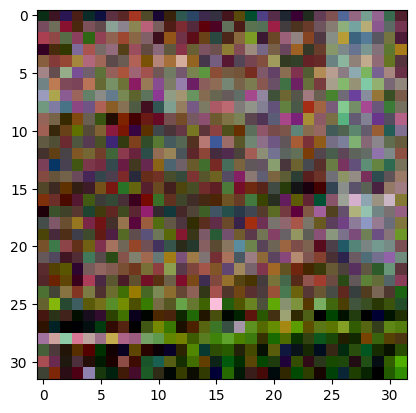

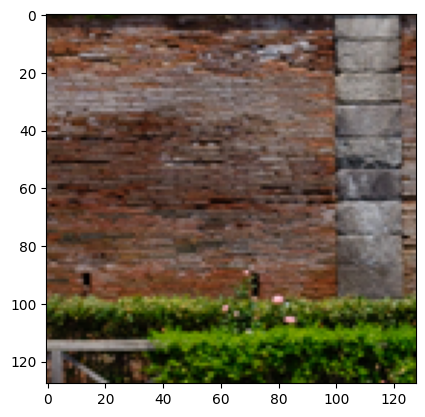

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 128, 128])


In [34]:
image_helper = ImageHelper()
i = 0
for x, y in train_dataloader:
    i += 1
    if i > 2:
        break
    image_helper.show_tensor_as_image(x[0])
    image_helper.show_tensor_as_image(y[0])
    print(x.shape)
    print(y.shape)
    break

In [8]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-3
model_betas = (0.9, 0.999)

# Total number of epochs
epochs = 100

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                             eta_min = 1e-6) # Minimum learning rate.

In [19]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=scheduler,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-with-noise-cuda-1.txt'
)


epoch 0
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:15<00:00,  3.14it/s]


Training Error: 
 Avg loss: 0.009380 



100%|██████████| 197/197 [00:25<00:00,  7.72it/s]


Validation Error: 
 Avg loss: 0.005821 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009997535269026829
Epoch: 0
Time: 463.76128220558167
Learning rate: 0.0009997535269026829
Train loss: 0.009380392723087744
Validation loss: 0.005821349875774556
Elapsed time: 463.761353969574

epoch 1
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:21<00:00,  3.10it/s]


Training Error: 
 Avg loss: 0.005967 



100%|██████████| 197/197 [00:24<00:00,  7.98it/s]


Validation Error: 
 Avg loss: 0.005672 

Learning rate (antes): 0.0009997535269026829
Learning rate (depois): 0.0009990143508499217
Epoch: 1
Time: 468.927122592926
Learning rate: 0.0009990143508499217
Train loss: 0.005966677970207999
Validation loss: 0.005672360469615513
Elapsed time: 468.92719888687134

epoch 2
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:13<00:00,  3.15it/s]


Training Error: 
 Avg loss: 0.005912 



100%|██████████| 197/197 [00:24<00:00,  8.09it/s]


Validation Error: 
 Avg loss: 0.005796 

Learning rate (antes): 0.0009990143508499217
Learning rate (depois): 0.0009977832013192385
Epoch: 2
Time: 460.55493545532227
Learning rate: 0.0009977832013192385
Train loss: 0.005911825398869584
Validation loss: 0.005796304482583732
Elapsed time: 460.55500411987305

epoch 3
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:13<00:00,  3.16it/s]


Training Error: 
 Avg loss: 0.005872 



100%|██████████| 197/197 [00:24<00:00,  8.09it/s]


Validation Error: 
 Avg loss: 0.005759 

Learning rate (antes): 0.0009977832013192385
Learning rate (depois): 0.0009960612933065818
Epoch: 3
Time: 460.04153752326965
Learning rate: 0.0009960612933065818
Train loss: 0.005872241160267288
Validation loss: 0.005759160521293655
Elapsed time: 460.0416042804718

epoch 4
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:12<00:00,  3.16it/s]


Training Error: 
 Avg loss: 0.005881 



100%|██████████| 197/197 [00:24<00:00,  8.10it/s]


Validation Error: 
 Avg loss: 0.005686 

Learning rate (antes): 0.0009960612933065818
Learning rate (depois): 0.0009938503261272714
Epoch: 4
Time: 459.6055073738098
Learning rate: 0.0009938503261272714
Train loss: 0.005880567386619779
Validation loss: 0.0056863796630127325
Elapsed time: 459.60558462142944

epoch 5
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:11<00:00,  3.17it/s]


Training Error: 
 Avg loss: 0.005868 



100%|██████████| 197/197 [00:24<00:00,  8.12it/s]


Validation Error: 
 Avg loss: 0.005722 

Learning rate (antes): 0.0009938503261272714
Learning rate (depois): 0.00099115248173898
Epoch: 5
Time: 458.3495635986328
Learning rate: 0.00099115248173898
Train loss: 0.005868484305928608
Validation loss: 0.005721980613079584
Elapsed time: 458.3496334552765

epoch 6
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.005856 



100%|██████████| 197/197 [00:24<00:00,  8.14it/s]


Validation Error: 
 Avg loss: 0.005654 

Learning rate (antes): 0.00099115248173898
Learning rate (depois): 0.0009879704225884043
Epoch: 6
Time: 455.679806470871
Learning rate: 0.0009879704225884043
Train loss: 0.0058557365243854164
Validation loss: 0.005654050090449489
Elapsed time: 455.6798768043518

epoch 7
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:06<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.005851 



100%|██████████| 197/197 [00:24<00:00,  8.16it/s]


Validation Error: 
 Avg loss: 0.005674 

Learning rate (antes): 0.0009879704225884043
Learning rate (depois): 0.0009843072889837512
Epoch: 7
Time: 453.0480275154114
Learning rate: 0.0009843072889837512
Train loss: 0.005850733537805588
Validation loss: 0.0056744036311992836
Elapsed time: 453.0481004714966

epoch 8
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:04<00:00,  3.22it/s]


Training Error: 
 Avg loss: 0.005838 



100%|██████████| 197/197 [00:24<00:00,  8.19it/s]


Validation Error: 
 Avg loss: 0.005693 

Learning rate (antes): 0.0009843072889837512
Learning rate (depois): 0.000980166695995633
Epoch: 8
Time: 451.5335521697998
Learning rate: 0.000980166695995633
Train loss: 0.005837723840169652
Validation loss: 0.005692920219720469
Elapsed time: 451.53362488746643

epoch 9
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.006281 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005861 

Learning rate (antes): 0.000980166695995633
Learning rate (depois): 0.0009755527298894294
Epoch: 9
Time: 450.4909257888794
Learning rate: 0.0009755527298894294
Train loss: 0.006281133525159308
Validation loss: 0.005861409324065305
Elapsed time: 450.49099469184875

epoch 10
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005888 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005680 

Learning rate (antes): 0.0009755527298894294
Learning rate (depois): 0.0009704699440926358
Epoch: 10
Time: 450.23922324180603
Learning rate: 0.0009704699440926358
Train loss: 0.00588836165809492
Validation loss: 0.005679697324261826
Elapsed time: 450.2392919063568

epoch 11
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005849 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005677 

Learning rate (antes): 0.0009704699440926358
Learning rate (depois): 0.0009649233547011817
Epoch: 11
Time: 449.92608165740967
Learning rate: 0.0009649233547011817
Train loss: 0.005849232601018198
Validation loss: 0.005676868376393003
Elapsed time: 449.9261486530304

epoch 12
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005861 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005687 

Learning rate (antes): 0.0009649233547011817
Learning rate (depois): 0.0009589184355291487
Epoch: 12
Time: 449.7409608364105
Learning rate: 0.0009589184355291487
Train loss: 0.005860551311471091
Validation loss: 0.005686640275552453
Elapsed time: 449.7410252094269

epoch 13
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005837 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005661 

Learning rate (antes): 0.0009589184355291487
Learning rate (depois): 0.000952461112706777
Epoch: 13
Time: 449.6137752532959
Learning rate: 0.000952461112706777
Train loss: 0.005837061403289285
Validation loss: 0.0056605560983989745
Elapsed time: 449.6138439178467

epoch 14
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.006083 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005726 

Learning rate (antes): 0.000952461112706777
Learning rate (depois): 0.00094555775883209
Epoch: 14
Time: 449.4018578529358
Learning rate: 0.00094555775883209
Train loss: 0.006083188348378964
Validation loss: 0.005725580460845781
Elapsed time: 449.40192556381226

epoch 15
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005849 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005696 

Learning rate (antes): 0.00094555775883209
Learning rate (depois): 0.0009382151866819101
Epoch: 15
Time: 449.45436358451843
Learning rate: 0.0009382151866819101
Train loss: 0.005849204734015436
Validation loss: 0.005695506374866981
Elapsed time: 449.45442938804626

epoch 16
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005829 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005691 

Learning rate (antes): 0.0009382151866819101
Learning rate (depois): 0.0009304406424884702
Epoch: 16
Time: 449.11423778533936
Learning rate: 0.0009304406424884702
Train loss: 0.005829114291772018
Validation loss: 0.005690806889244672
Elapsed time: 449.11430621147156

epoch 17
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005818 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005658 

Learning rate (antes): 0.0009304406424884702
Learning rate (depois): 0.000922241798788257
Epoch: 17
Time: 448.97764706611633
Learning rate: 0.000922241798788257
Train loss: 0.005817919186818854
Validation loss: 0.005657854068641395
Elapsed time: 448.9777135848999

epoch 18
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005810 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005670 

Learning rate (antes): 0.000922241798788257
Learning rate (depois): 0.0009136267468501441
Epoch: 18
Time: 448.89873361587524
Learning rate: 0.0009136267468501441
Train loss: 0.005809731569756585
Validation loss: 0.005669509716625065
Elapsed time: 448.89880323410034

epoch 19
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005805 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005669 

Learning rate (antes): 0.0009136267468501441
Learning rate (depois): 0.0009046039886902867
Epoch: 19
Time: 448.9118514060974
Learning rate: 0.0009046039886902867
Train loss: 0.005805257094441232
Validation loss: 0.0056688124491232755
Elapsed time: 448.9119167327881

epoch 20
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005908 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005684 

Learning rate (antes): 0.0009046039886902867
Learning rate (depois): 0.0008951824286816577
Epoch: 20
Time: 448.9645125865936
Learning rate: 0.0008951824286816577
Train loss: 0.005908344464161439
Validation loss: 0.005683647956212198
Elapsed time: 448.9645776748657

epoch 21
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005808 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005685 

Learning rate (antes): 0.0008951824286816577
Learning rate (depois): 0.0008853713647665071
Epoch: 21
Time: 449.05197644233704
Learning rate: 0.0008853713647665071
Train loss: 0.005808064112254576
Validation loss: 0.005685179793337351
Elapsed time: 449.05204248428345

epoch 22
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005807 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005689 

Learning rate (antes): 0.0008853713647665071
Learning rate (depois): 0.0008751804792804149
Epoch: 22
Time: 449.12267661094666
Learning rate: 0.0008751804792804149
Train loss: 0.005806589137615734
Validation loss: 0.005689472192898393
Elapsed time: 449.1227424144745

epoch 23
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005802 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005661 

Learning rate (antes): 0.0008751804792804149
Learning rate (depois): 0.0008646198293969954
Epoch: 23
Time: 448.9283244609833
Learning rate: 0.0008646198293969954
Train loss: 0.005802445767048409
Validation loss: 0.005660843413777006
Elapsed time: 448.9283916950226

epoch 24
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005819 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005658 

Learning rate (antes): 0.0008646198293969954
Learning rate (depois): 0.0008536998372026807
Epoch: 24
Time: 449.10839200019836
Learning rate: 0.0008536998372026807
Train loss: 0.005818795701944983
Validation loss: 0.005657520411101165
Elapsed time: 449.1084623336792

epoch 25
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005798 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005716 

Learning rate (antes): 0.0008536998372026807
Learning rate (depois): 0.0008424312794113804
Epoch: 25
Time: 449.18492221832275
Learning rate: 0.0008424312794113804
Train loss: 0.005797843933200779
Validation loss: 0.005716210040311107
Elapsed time: 449.18499088287354

epoch 26
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.006116 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005697 

Learning rate (antes): 0.0008424312794113804
Learning rate (depois): 0.0008308252767291644
Epoch: 26
Time: 449.0649399757385
Learning rate: 0.0008308252767291644
Train loss: 0.006116374262693006
Validation loss: 0.00569661813528102
Elapsed time: 449.06502747535706

epoch 27
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005813 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005684 

Learning rate (antes): 0.0008308252767291644
Learning rate (depois): 0.0008188932828794708
Epoch: 27
Time: 449.3391845226288
Learning rate: 0.0008188932828794708
Train loss: 0.005812511793494344
Validation loss: 0.00568357235184743
Elapsed time: 449.3392496109009

epoch 28
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005802 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005657 

Learning rate (antes): 0.0008188932828794708
Learning rate (depois): 0.0008066470732996621
Epoch: 28
Time: 449.4970910549164
Learning rate: 0.0008066470732996621
Train loss: 0.00580199692181818
Validation loss: 0.00565690022295218
Elapsed time: 449.4971568584442

epoch 29
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005798 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005660 

Learning rate (antes): 0.0008066470732996621
Learning rate (depois): 0.0007940987335200907
Epoch: 29
Time: 449.3242838382721
Learning rate: 0.0007940987335200907
Train loss: 0.00579775550010565
Validation loss: 0.005659705239494666
Elapsed time: 449.3243544101715

epoch 30
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005793 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005661 

Learning rate (antes): 0.0007940987335200907
Learning rate (depois): 0.0007812606472371396
Epoch: 30
Time: 449.1275689601898
Learning rate: 0.0007812606472371396
Train loss: 0.005793253854066896
Validation loss: 0.005661003536256361
Elapsed time: 449.12763810157776

epoch 31
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005789 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005652 

Learning rate (antes): 0.0007812606472371396
Learning rate (depois): 0.0007681454840920091
Epoch: 31
Time: 449.16711616516113
Learning rate: 0.0007681454840920091
Train loss: 0.005788534068181152
Validation loss: 0.005652037747015203
Elapsed time: 449.1671817302704

epoch 32
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005787 



100%|██████████| 197/197 [00:24<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005647 

Learning rate (antes): 0.0007681454840920091
Learning rate (depois): 0.0007547661871673109
Epoch: 32
Time: 449.21497678756714
Learning rate: 0.0007547661871673109
Train loss: 0.005787355278459329
Validation loss: 0.005646989371173727
Elapsed time: 449.2150423526764

epoch 33
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.006194 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005695 

Learning rate (antes): 0.0007547661871673109
Learning rate (depois): 0.0007411359602138072
Epoch: 33
Time: 449.2309145927429
Learning rate: 0.0007411359602138072
Train loss: 0.0061936153901253465
Validation loss: 0.005695102095774134
Elapsed time: 449.2309811115265

epoch 34
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.005816 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005673 

Learning rate (antes): 0.0007411359602138072
Learning rate (depois): 0.000727268254619904
Epoch: 34
Time: 449.61094522476196
Learning rate: 0.000727268254619904
Train loss: 0.005816441002589165
Validation loss: 0.005673438258620386
Elapsed time: 449.6110129356384

epoch 35
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005797 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005656 

Learning rate (antes): 0.000727268254619904
Learning rate (depois): 0.0007131767561367542
Epoch: 35
Time: 449.20850825309753
Learning rate: 0.0007131767561367542
Train loss: 0.005797004071540848
Validation loss: 0.005656454954438176
Elapsed time: 449.208575963974

epoch 36
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005791 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005656 

Learning rate (antes): 0.0007131767561367542
Learning rate (depois): 0.0006988753713720732
Epoch: 36
Time: 448.9624435901642
Learning rate: 0.0006988753713720732
Train loss: 0.005790813186591252
Validation loss: 0.005655700951899747
Elapsed time: 448.9625098705292

epoch 37
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005790 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005635 

Learning rate (antes): 0.0006988753713720732
Learning rate (depois): 0.000684378214065997
Epoch: 37
Time: 449.0303747653961
Learning rate: 0.000684378214065997
Train loss: 0.005790026381214242
Validation loss: 0.005635125283033677
Elapsed time: 449.0304431915283

epoch 38
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005785 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005646 

Learning rate (antes): 0.000684378214065997
Learning rate (depois): 0.0006696995911625234
Epoch: 38
Time: 449.06577610969543
Learning rate: 0.0006696995911625234
Train loss: 0.005784916777602174
Validation loss: 0.005645656544563885
Elapsed time: 449.0658450126648

epoch 39
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005781 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005641 

Learning rate (antes): 0.0006696995911625234
Learning rate (depois): 0.0006548539886902865
Epoch: 39
Time: 449.0470383167267
Learning rate: 0.0006548539886902865
Train loss: 0.005780533764903483
Validation loss: 0.005640613218310861
Elapsed time: 449.0471065044403

epoch 40
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005981 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005661 

Learning rate (antes): 0.0006548539886902865
Learning rate (depois): 0.0006398560574665953
Epoch: 40
Time: 448.9504773616791
Learning rate: 0.0006398560574665953
Train loss: 0.005981087246712308
Validation loss: 0.005661445890841675
Elapsed time: 448.9505441188812

epoch 41
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005785 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005640 

Learning rate (antes): 0.0006398560574665953
Learning rate (depois): 0.0006247205986388451
Epoch: 41
Time: 448.91134905815125
Learning rate: 0.0006247205986388451
Train loss: 0.005784624607481977
Validation loss: 0.005640279409489807
Elapsed time: 448.91141724586487

epoch 42
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005780 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005635 

Learning rate (antes): 0.0006247205986388451
Learning rate (depois): 0.0006094625490775733
Epoch: 42
Time: 448.96434259414673
Learning rate: 0.0006094625490775733
Train loss: 0.005780388022451634
Validation loss: 0.005635355749914451
Elapsed time: 448.9644093513489

epoch 43
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005778 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005657 

Learning rate (antes): 0.0006094625490775733
Learning rate (depois): 0.0005940969666355698
Epoch: 43
Time: 449.0420663356781
Learning rate: 0.0005940969666355698
Train loss: 0.0057777292120654395
Validation loss: 0.005657204464645253
Elapsed time: 449.0421326160431

epoch 44
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005772 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005633 

Learning rate (antes): 0.0005940969666355698
Learning rate (depois): 0.0005786390152875956
Epoch: 44
Time: 448.94276428222656
Learning rate: 0.0005786390152875956
Train loss: 0.0057720623517950875
Validation loss: 0.005633114011565857
Elapsed time: 448.9428324699402

epoch 45
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005771 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005627 

Learning rate (antes): 0.0005786390152875956
Learning rate (depois): 0.0005631039501653703
Epoch: 45
Time: 448.6993455886841
Learning rate: 0.0005631039501653703
Train loss: 0.005770573646785985
Validation loss: 0.005627272681919338
Elapsed time: 448.6994137763977

epoch 46
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005770 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005633 

Learning rate (antes): 0.0005631039501653703
Learning rate (depois): 0.0005475071025025981
Epoch: 46
Time: 448.85470032691956
Learning rate: 0.0005475071025025981
Train loss: 0.005770055346030262
Validation loss: 0.005633207893727092
Elapsed time: 448.8547694683075

epoch 47
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005766 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005629 

Learning rate (antes): 0.0005475071025025981
Learning rate (depois): 0.0005318638645048923
Epoch: 47
Time: 448.9264717102051
Learning rate: 0.0005318638645048923
Train loss: 0.005766490286615083
Validation loss: 0.0056288922276480245
Elapsed time: 448.92654395103455

epoch 48
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005766 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005620 

Learning rate (antes): 0.0005318638645048923
Learning rate (depois): 0.0005161896741595253
Epoch: 48
Time: 448.77679347991943
Learning rate: 0.0005161896741595253
Train loss: 0.005765944918275849
Validation loss: 0.005620014960144831
Elapsed time: 448.776859998703

epoch 49
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005887 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005653 

Learning rate (antes): 0.0005161896741595253
Learning rate (depois): 0.0005005000000000002
Epoch: 49
Time: 448.635529756546
Learning rate: 0.0005005000000000002
Train loss: 0.0058870790597753955
Validation loss: 0.005653052031757489
Elapsed time: 448.6355984210968

epoch 50
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005772 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005676 

Learning rate (antes): 0.0005005000000000002
Learning rate (depois): 0.0004848103258404751
Epoch: 50
Time: 449.0100824832916
Learning rate: 0.0004848103258404751
Train loss: 0.005771789559890239
Validation loss: 0.005675519897536313
Elapsed time: 449.0101499557495

epoch 51
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005767 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005648 

Learning rate (antes): 0.0004848103258404751
Learning rate (depois): 0.0004691361354951082
Epoch: 51
Time: 449.0347988605499
Learning rate: 0.0004691361354951082
Train loss: 0.005766964919711273
Validation loss: 0.005648439747120637
Elapsed time: 449.0348653793335

epoch 52
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005765 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005627 

Learning rate (antes): 0.0004691361354951082
Learning rate (depois): 0.00045349289749740224
Epoch: 52
Time: 449.01462864875793
Learning rate: 0.00045349289749740224
Train loss: 0.005765164426217477
Validation loss: 0.005626629677549156
Elapsed time: 449.0146963596344

epoch 53
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005763 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005615 

Learning rate (antes): 0.00045349289749740224
Learning rate (depois): 0.0004378960498346302
Epoch: 53
Time: 449.09279894828796
Learning rate: 0.0004378960498346302
Train loss: 0.0057629014238407454
Validation loss: 0.005614746580618968
Elapsed time: 449.0928695201874

epoch 54
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005760 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005618 

Learning rate (antes): 0.0004378960498346302
Learning rate (depois): 0.0004223609847124048
Epoch: 54
Time: 448.94289541244507
Learning rate: 0.0004223609847124048
Train loss: 0.005760293818155184
Validation loss: 0.0056177996344826545
Elapsed time: 448.9429678916931

epoch 55
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005759 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005624 

Learning rate (antes): 0.0004223609847124048
Learning rate (depois): 0.0004069030333644307
Epoch: 55
Time: 448.85716342926025
Learning rate: 0.0004069030333644307
Train loss: 0.005759191483344981
Validation loss: 0.005624358343707426
Elapsed time: 448.8572292327881

epoch 56
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005756 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005622 

Learning rate (antes): 0.0004069030333644307
Learning rate (depois): 0.0003915374509224273
Epoch: 56
Time: 448.8051664829254
Learning rate: 0.0003915374509224273
Train loss: 0.005756184257558759
Validation loss: 0.005621794912004418
Elapsed time: 448.8052351474762

epoch 57
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005756 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005631 

Learning rate (antes): 0.0003915374509224273
Learning rate (depois): 0.0003762794013611551
Epoch: 57
Time: 448.8492658138275
Learning rate: 0.0003762794013611551
Train loss: 0.005755946417992706
Validation loss: 0.005631423469037195
Elapsed time: 448.8493330478668

epoch 58
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005755 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005616 

Learning rate (antes): 0.0003762794013611551
Learning rate (depois): 0.00036114394253340513
Epoch: 58
Time: 448.86919927597046
Learning rate: 0.00036114394253340513
Train loss: 0.00575531830371913
Validation loss: 0.00561586546777809
Elapsed time: 448.86927032470703

epoch 59
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005772 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005622 

Learning rate (antes): 0.00036114394253340513
Learning rate (depois): 0.000346146011309714
Epoch: 59
Time: 448.9356484413147
Learning rate: 0.000346146011309714
Train loss: 0.00577186252029983
Validation loss: 0.005622009905102441
Elapsed time: 448.93572187423706

epoch 60
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005751 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005616 

Learning rate (antes): 0.000346146011309714
Learning rate (depois): 0.00033130040883747703
Epoch: 60
Time: 448.9435830116272
Learning rate: 0.00033130040883747703
Train loss: 0.005751294985261054
Validation loss: 0.005615553363027798
Elapsed time: 448.94365668296814

epoch 61
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005751 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005611 

Learning rate (antes): 0.00033130040883747703
Learning rate (depois): 0.0003166217859340036
Epoch: 61
Time: 448.93638157844543
Learning rate: 0.0003166217859340036
Train loss: 0.005751396630303825
Validation loss: 0.005611129529386532
Elapsed time: 448.93644976615906

epoch 62
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005751 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005613 

Learning rate (antes): 0.0003166217859340036
Learning rate (depois): 0.0003021246286279271
Epoch: 62
Time: 448.8074645996094
Learning rate: 0.0003021246286279271
Train loss: 0.005751086115239362
Validation loss: 0.0056125336151740274
Elapsed time: 448.807532787323

epoch 63
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005748 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005620 

Learning rate (antes): 0.0003021246286279271
Learning rate (depois): 0.00028782324386324626
Epoch: 63
Time: 448.9402189254761
Learning rate: 0.00028782324386324626
Train loss: 0.005747701116798076
Validation loss: 0.005619912196144575
Elapsed time: 448.94028759002686

epoch 64
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005748 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005629 

Learning rate (antes): 0.00028782324386324626
Learning rate (depois): 0.00027373174538009644
Epoch: 64
Time: 448.86851477622986
Learning rate: 0.00027373174538009644
Train loss: 0.0057483898856668944
Validation loss: 0.005629281979054213
Elapsed time: 448.86858582496643

epoch 65
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005748 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005618 

Learning rate (antes): 0.00027373174538009644
Learning rate (depois): 0.00025986403978619317
Epoch: 65
Time: 448.79484963417053
Learning rate: 0.00025986403978619317
Train loss: 0.005747895616335435
Validation loss: 0.0056184483077471635
Elapsed time: 448.79491806030273

epoch 66
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005747 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005605 

Learning rate (antes): 0.00025986403978619317
Learning rate (depois): 0.00024623381283268956
Epoch: 66
Time: 448.6707355976105
Learning rate: 0.00024623381283268956
Train loss: 0.005746590689591225
Validation loss: 0.005604880396867653
Elapsed time: 448.6708393096924

epoch 67
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005746 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005611 

Learning rate (antes): 0.00024623381283268956
Learning rate (depois): 0.00023285451590799108
Epoch: 67
Time: 448.74600172042847
Learning rate: 0.00023285451590799108
Train loss: 0.005745773184438622
Validation loss: 0.005611019680597985
Elapsed time: 448.7460699081421

epoch 68
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005744 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005606 

Learning rate (antes): 0.00023285451590799108
Learning rate (depois): 0.00021973935276286074
Epoch: 68
Time: 448.64714217185974
Learning rate: 0.00021973935276286074
Train loss: 0.0057438120890302554
Validation loss: 0.0056056584306013995
Elapsed time: 448.6472146511078

epoch 69
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005743 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005623 

Learning rate (antes): 0.00021973935276286074
Learning rate (depois): 0.00020690126647990976
Epoch: 69
Time: 448.6877553462982
Learning rate: 0.00020690126647990976
Train loss: 0.005743053609339183
Validation loss: 0.005622943213828816
Elapsed time: 448.68782663345337

epoch 70
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005743 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005609 

Learning rate (antes): 0.00020690126647990976
Learning rate (depois): 0.00019435292670033822
Epoch: 70
Time: 448.54359459877014
Learning rate: 0.00019435292670033822
Train loss: 0.005743200822810953
Validation loss: 0.005609301233848529
Elapsed time: 448.54366183280945

epoch 71
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005742 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005602 

Learning rate (antes): 0.00019435292670033822
Learning rate (depois): 0.0001821067171205295
Epoch: 71
Time: 448.68868923187256
Learning rate: 0.0001821067171205295
Train loss: 0.005741730949171541
Validation loss: 0.005602149873130439
Elapsed time: 448.6887581348419

epoch 72
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005742 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005609 

Learning rate (antes): 0.0001821067171205295
Learning rate (depois): 0.000170174723270836
Epoch: 72
Time: 448.81829738616943
Learning rate: 0.000170174723270836
Train loss: 0.00574183178083884
Validation loss: 0.0056089472154457936
Elapsed time: 448.81837224960327

epoch 73
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005740 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005601 

Learning rate (antes): 0.000170174723270836
Learning rate (depois): 0.00015856872058862001
Epoch: 73
Time: 448.60483717918396
Learning rate: 0.00015856872058862001
Train loss: 0.0057403825549204555
Validation loss: 0.005600724815447734
Elapsed time: 448.60490441322327

epoch 74
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005740 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005602 

Learning rate (antes): 0.00015856872058862001
Learning rate (depois): 0.00014730016279731957
Epoch: 74
Time: 448.51220893859863
Learning rate: 0.00014730016279731957
Train loss: 0.005739947013374505
Validation loss: 0.005602487970408298
Elapsed time: 448.5122754573822

epoch 75
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005739 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005603 

Learning rate (antes): 0.00014730016279731957
Learning rate (depois): 0.00013638017060300508
Epoch: 75
Time: 448.65941643714905
Learning rate: 0.00013638017060300508
Train loss: 0.005738954311672446
Validation loss: 0.005603246097712952
Elapsed time: 448.6594841480255

epoch 76
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005739 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005602 

Learning rate (antes): 0.00013638017060300508
Learning rate (depois): 0.00012581952071958545
Epoch: 76
Time: 448.42992329597473
Learning rate: 0.00012581952071958545
Train loss: 0.00573885119901371
Validation loss: 0.0056018345394800535
Elapsed time: 448.42999362945557

epoch 77
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005737 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005601 

Learning rate (antes): 0.00012581952071958545
Learning rate (depois): 0.00011562863523349334
Epoch: 77
Time: 448.23362040519714
Learning rate: 0.00011562863523349334
Train loss: 0.005737496470169257
Validation loss: 0.005600887523292739
Elapsed time: 448.2336914539337

epoch 78
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005736 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005596 

Learning rate (antes): 0.00011562863523349334
Learning rate (depois): 0.00010581757131834266
Epoch: 78
Time: 448.37576150894165
Learning rate: 0.00010581757131834266
Train loss: 0.005736352471438677
Validation loss: 0.0055963416976220716
Elapsed time: 448.3758306503296

epoch 79
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005737 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005605 

Learning rate (antes): 0.00010581757131834266
Learning rate (depois): 9.639601130971382e-05
Epoch: 79
Time: 448.34931802749634
Learning rate: 9.639601130971382e-05
Train loss: 0.005736587596859794
Validation loss: 0.005604591630139213
Elapsed time: 448.34941577911377

epoch 80
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005735 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005598 

Learning rate (antes): 9.639601130971382e-05
Learning rate (depois): 8.737325314985643e-05
Epoch: 80
Time: 448.24073672294617
Learning rate: 8.737325314985643e-05
Train loss: 0.0057354118317237655
Validation loss: 0.005598460608942027
Elapsed time: 448.24080419540405

epoch 81
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005735 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005601 

Learning rate (antes): 8.737325314985643e-05
Learning rate (depois): 7.875820121174359e-05
Epoch: 81
Time: 448.1803514957428
Learning rate: 7.875820121174359e-05
Train loss: 0.005735012966280323
Validation loss: 0.005600877363248941
Elapsed time: 448.18041825294495

epoch 82
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005734 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005597 

Learning rate (antes): 7.875820121174359e-05
Learning rate (depois): 7.05593575115301e-05
Epoch: 82
Time: 448.41708064079285
Learning rate: 7.05593575115301e-05
Train loss: 0.005733950788458831
Validation loss: 0.005596857288672688
Elapsed time: 448.4171483516693

epoch 83
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005734 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005598 

Learning rate (antes): 7.05593575115301e-05
Learning rate (depois): 6.278481331809015e-05
Epoch: 83
Time: 448.11028242111206
Learning rate: 6.278481331809015e-05
Train loss: 0.005734161212046397
Validation loss: 0.00559823092683053
Elapsed time: 448.11035418510437

epoch 84
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005733 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005597 

Learning rate (antes): 6.278481331809015e-05
Learning rate (depois): 5.54422411679103e-05
Epoch: 84
Time: 448.44297981262207
Learning rate: 5.54422411679103e-05
Train loss: 0.005733172802904032
Validation loss: 0.005596629876955436
Elapsed time: 448.4430482387543

epoch 85
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005732 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005597 

Learning rate (antes): 5.54422411679103e-05
Learning rate (depois): 4.853888729322334e-05
Epoch: 85
Time: 448.7532148361206
Learning rate: 4.853888729322334e-05
Train loss: 0.005732121057359077
Validation loss: 0.005597139274947307
Elapsed time: 448.75328278541565

epoch 86
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005732 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005596 

Learning rate (antes): 4.853888729322334e-05
Learning rate (depois): 4.2081564470851536e-05
Epoch: 86
Time: 448.3719906806946
Learning rate: 4.2081564470851536e-05
Train loss: 0.005732174467823702
Validation loss: 0.005595504326348756
Elapsed time: 448.37205934524536

epoch 87
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005732 



100%|██████████| 197/197 [00:24<00:00,  8.20it/s]


Validation Error: 
 Avg loss: 0.005598 

Learning rate (antes): 4.2081564470851536e-05
Learning rate (depois): 3.6076645298818454e-05
Epoch: 87
Time: 448.2765848636627
Learning rate: 3.6076645298818454e-05
Train loss: 0.005731790118553942
Validation loss: 0.0055983891517992325
Elapsed time: 448.2766532897949

epoch 88
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.005731 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005595 

Learning rate (antes): 3.6076645298818454e-05
Learning rate (depois): 3.053005590736439e-05
Epoch: 88
Time: 448.28434920310974
Learning rate: 3.053005590736439e-05
Train loss: 0.005731193143336582
Validation loss: 0.005595212666965492
Elapsed time: 448.2844223976135

epoch 89
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005731 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005596 

Learning rate (antes): 3.053005590736439e-05
Learning rate (depois): 2.5447270110570814e-05
Epoch: 89
Time: 447.8320550918579
Learning rate: 2.5447270110570814e-05
Train loss: 0.0057305999744236905
Validation loss: 0.005596290346646332
Elapsed time: 447.8321228027344

epoch 90
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005730 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005594 

Learning rate (antes): 2.5447270110570814e-05
Learning rate (depois): 2.0833304004366997e-05
Epoch: 90
Time: 447.7816894054413
Learning rate: 2.0833304004366997e-05
Train loss: 0.0057303549329360826
Validation loss: 0.005594260098299172
Elapsed time: 447.78176045417786

epoch 91
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005730 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005595 

Learning rate (antes): 2.0833304004366997e-05
Learning rate (depois): 1.6692711016248837e-05
Epoch: 91
Time: 447.81607937812805
Learning rate: 1.6692711016248837e-05
Train loss: 0.005730420271375854
Validation loss: 0.005594813305090375
Elapsed time: 447.8161482810974

epoch 92
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:01<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005730 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005596 

Learning rate (antes): 1.6692711016248837e-05
Learning rate (depois): 1.3029577411595715e-05
Epoch: 92
Time: 447.7020192146301
Learning rate: 1.3029577411595715e-05
Train loss: 0.005729824705056203
Validation loss: 0.005595777327960669
Elapsed time: 447.702086687088

epoch 93
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:00<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005595 

Learning rate (antes): 1.3029577411595715e-05
Learning rate (depois): 9.847518261019987e-06
Epoch: 93
Time: 447.34656858444214
Learning rate: 9.847518261019987e-06
Train loss: 0.005728735986243312
Validation loss: 0.00559502316173166
Elapsed time: 447.34663581848145

epoch 94
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:00<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.24it/s]


Validation Error: 
 Avg loss: 0.005593 

Learning rate (antes): 9.847518261019987e-06
Learning rate (depois): 7.14967387272874e-06
Epoch: 94
Time: 446.86125349998474
Learning rate: 7.14967387272874e-06
Train loss: 0.005729318629611251
Validation loss: 0.005593365733157181
Elapsed time: 446.86132073402405

epoch 95
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:59<00:00,  3.26it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.25it/s]


Validation Error: 
 Avg loss: 0.005595 

Learning rate (antes): 7.14967387272874e-06
Learning rate (depois): 4.9387066934183575e-06
Epoch: 95
Time: 446.17521715164185
Learning rate: 4.9387066934183575e-06
Train loss: 0.005728768840893744
Validation loss: 0.005594645607932873
Elapsed time: 446.17528557777405

epoch 96
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:59<00:00,  3.26it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.23it/s]


Validation Error: 
 Avg loss: 0.005593 

Learning rate (antes): 4.9387066934183575e-06
Learning rate (depois): 3.2167986807615425e-06
Epoch: 96
Time: 446.2051627635956
Learning rate: 3.2167986807615425e-06
Train loss: 0.005728538363405411
Validation loss: 0.005593042148792464
Elapsed time: 446.2052297592163

epoch 97
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:59<00:00,  3.26it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.22it/s]


Validation Error: 
 Avg loss: 0.005594 

Learning rate (antes): 3.2167986807615425e-06
Learning rate (depois): 1.9856491500783564e-06
Epoch: 97
Time: 446.2034418582916
Learning rate: 1.9856491500783564e-06
Train loss: 0.0057285475440470406
Validation loss: 0.005594146450943678
Elapsed time: 446.2035114765167

epoch 98
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:00<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:24<00:00,  8.21it/s]


Validation Error: 
 Avg loss: 0.005594 

Learning rate (antes): 1.9856491500783564e-06
Learning rate (depois): 1.2464730973170658e-06
Epoch: 98
Time: 446.94663882255554
Learning rate: 1.2464730973170658e-06
Train loss: 0.005728687974964731
Validation loss: 0.0055936556817670615
Elapsed time: 446.94670963287354

epoch 99
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:00<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.005729 



100%|██████████| 197/197 [00:23<00:00,  8.21it/s]

Validation Error: 
 Avg loss: 0.005594 

Learning rate (antes): 1.2464730973170658e-06
Learning rate (depois): 1e-06
Epoch: 99
Time: 446.91261315345764
Learning rate: 1e-06
Train loss: 0.005728580674928564
Validation loss: 0.005594040566776421
Elapsed time: 446.91268253326416
CPU times: user 12h 22min 13s, sys: 8min 45s, total: 12h 30min 58s
Wall time: 12h 29min 23s


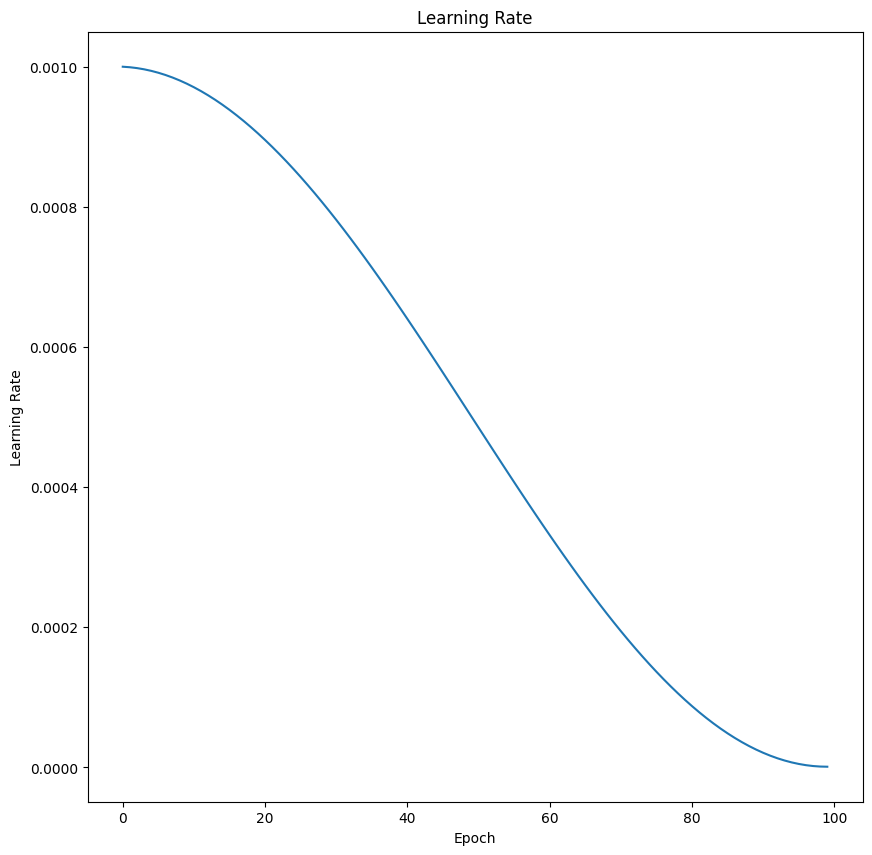

In [22]:
model_runner.plot_lr_from_df()

In [23]:
model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-with-noise-cuda-1-epoch=0-99.csv')
model_runner.save_model_weights(model, '../results/dbpn/trained_models/DBPN-real-run-medium-dataset-with-noise-cuda-1-epoch=0-99.pth')

In [24]:
df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-with-noise-cuda-1-epoch=0-99.csv')
df

,epoch,time,lr,train_loss,validation_loss
0,0,463.761280,0.001000,0.009380,0.005821
1,1,468.927122,0.000999,0.005967,0.005672
2,2,460.554933,0.000998,0.005912,0.005796
3,3,460.041537,0.000996,0.005872,0.005759
4,4,459.605506,0.000994,0.005881,0.005686
...,...,...,...,...,...
95,95,446.175216,0.000005,0.005729,0.005595
96,96,446.205162,0.000003,0.005729,0.005593
97,97,446.203441,0.000002,0.005729,0.005594
98,98,446.946637,0.000001,0.005729,0.005594


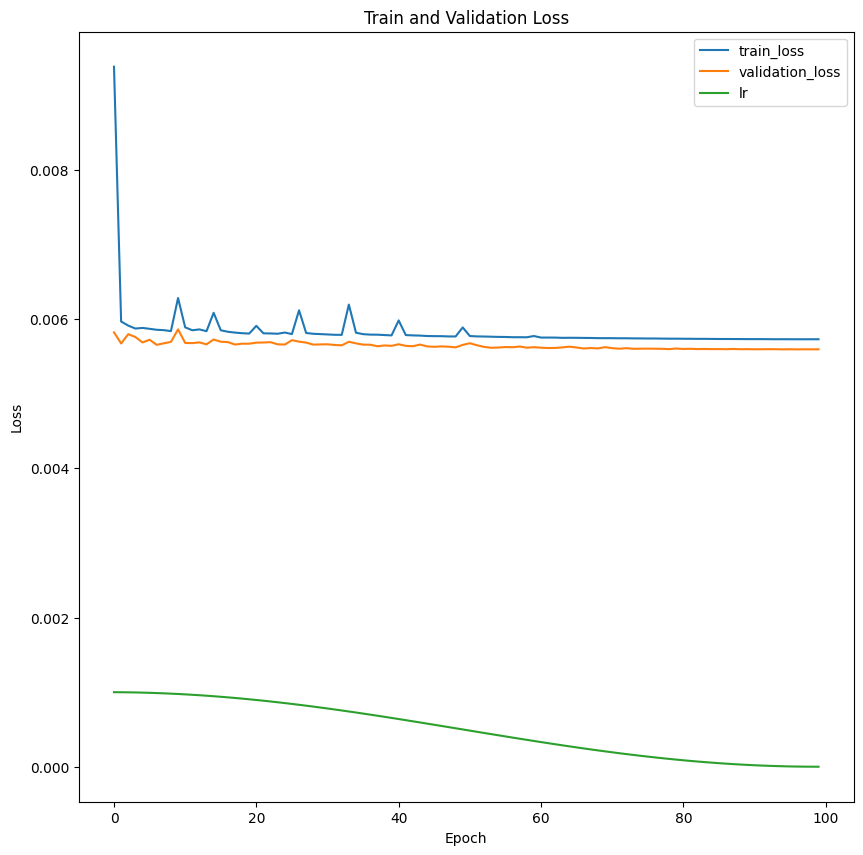

In [25]:
model_runner.plot_train_validation_loss_from_df()

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


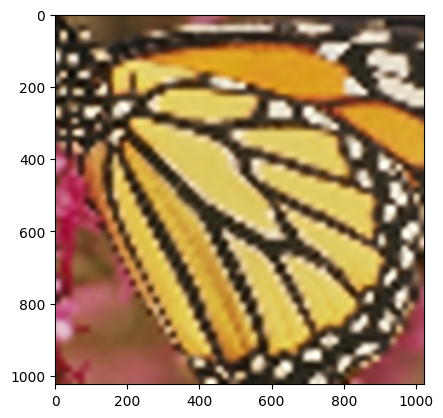

In [30]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    device=device
)

In [29]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.476372,0.600177
Bicubic,23.045410,0.632868
